In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]
subjects

['SW26_Unfam',
 'SW27_Fam',
 'SW20_Unfam',
 'SW22_Unfam',
 'SW23_Fam',
 'SW28_Unfam',
 'SW21_Fam',
 'SW34_Unfam',
 'SW25_Control',
 'SW19_Control',
 'SW24_Control',
 'SW31_Control',
 'SW30_Control',
 'SW32_Unfam',
 'SW29_Fam',
 'SW33_Fam',
 'SW35_Fam']

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
volumes

,id,atlas_id,name,st_level,parent_structure_id,depth,structure_id_path,safe_name,mean_volume,0,1,2,3,4,5,6,7,8,9,10
0,997,-1.0,root,0,NaN,0,/997/,root,435.287861,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,0.0,Basic cell groups and regions,1,997.0,1,/997/8/,Basic cell groups and regions,197.462441,997,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,567,70.0,Cerebrum,2,8.0,2,/997/8/567/,Cerebrum,120.883542,997,8.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,688,85.0,Cerebral cortex,3,567.0,3,/997/8/567/688/,Cerebral cortex,97.403809,997,8.0,567.0,688.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,695,86.0,Cortical plate,4,688.0,4,/997/8/567/688/695/,Cortical plate,93.461964,997,8.0,567.0,688.0,695.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,49,713.0,intraparafloccular fissure,8,1040.0,3,/997/1024/1040/49/,intraparafloccular fissure,NaN,997,1024.0,1040.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1323,57,714.0,paramedian sulcus,8,1040.0,3,/997/1024/1040/57/,paramedian sulcus,NaN,997,1024.0,1040.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1324,65,715.0,parafloccular sulcus,8,1040.0,3,/997/1024/1040/65/,parafloccular sulcus,NaN,997,1024.0,1040.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325,624,926.0,Interpeduncular fossa,7,1024.0,2,/997/1024/624/,Interpeduncular fossa,NaN,997,1024.0,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 100

In [7]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results_across_mice_SW19-35.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/pytho

In [8]:
dict_results_across_mice = np.load('dict_results_across_mice_SW19-35.npy', allow_pickle=True).item()

# List areas with null cell count

In [9]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

<AxesSubplot:>

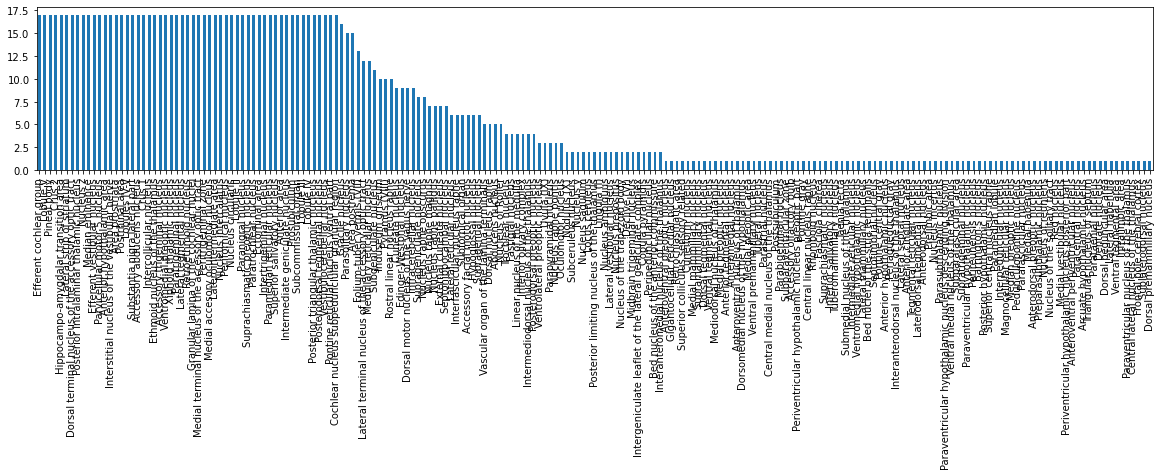

In [10]:
# make histogram of these
null_areas = [db_null_count[subjects[0]].area.values]
for subject in subjects[1:]:
    null_areas.append(db_null_count[subject].area.values)
null_areas = np.hstack(null_areas)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_areas).value_counts(sort=True).plot(kind='bar', axes=ax)


In [11]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_areas).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string(), len(df))

                 counts
Gracile nucleus      16 1


# List areas with no volume

In [12]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

<AxesSubplot:>

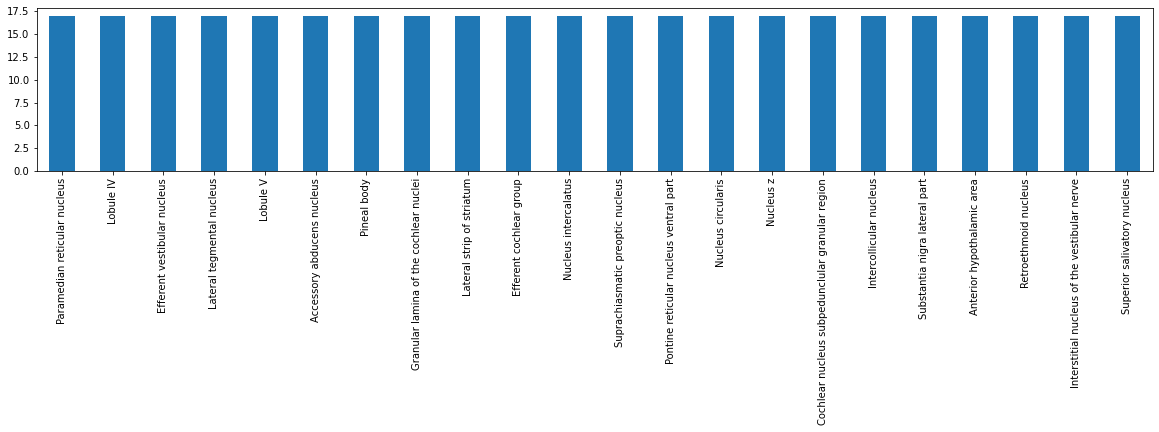

In [13]:
# make histogram of these
null_volume = [db_null_volume[subjects[0]].area.values]
for subject in subjects[1:]:
    null_volume.append(db_null_volume[subject].area.values)
null_volume = np.hstack(null_volume)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_volume).value_counts(sort=True).plot(kind='bar', axes=ax)

In [14]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_volume).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string())

Empty DataFrame
Columns: [counts]
Index: []


# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [15]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam',
  'SW23_Fam',
  'SW21_Fam',
  'SW29_Fam',
  'SW33_Fam',
  'SW35_Fam']}

# NB: We have only two mice for UNFAM group. Results there are not to be considered

# Calculate cell count across experimental groups

In [16]:
def calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='n_cells'):
    """
    Value can either be n_cells or energy
    """
    df_control = pd.DataFrame()
    df_fam = pd.DataFrame()
    df_unfam = pd.DataFrame()
    for subject in experimental_groups['Control']:
        df_control['area'] = dict_results_across_mice[subject]['area']
        df_control[subject] = dict_results_across_mice[subject][value]
    for subject in experimental_groups['Fam']:
        df_fam['area'] = dict_results_across_mice[subject]['area']
        df_fam[subject] = dict_results_across_mice[subject][value]
    for subject in experimental_groups['Unfam']:
        df_unfam['area'] = dict_results_across_mice[subject]['area']
        df_unfam[subject] = dict_results_across_mice[subject][value]
    return df_control, df_fam, df_unfam

In [17]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [18]:
df_control_cell_count

,area,SW25_Control,SW19_Control,SW24_Control,SW31_Control,SW30_Control
0,Frontal pole cerebral cortex,1578,341,615,851,649
1,Primary motor area,14016,4032,3948,7638,9453
2,Secondary motor area,24988,7158,8514,11586,15229
3,Primary somatosensory area,46055,9587,11168,20120,34024
4,Supplemental somatosensory area,13426,3370,1902,5101,8768
...,...,...,...,...,...,...
293,Flocculus,1715,127,1530,2008,233
294,Fastigial nucleus,2,0,1,116,68
295,Interposed nucleus,42,3,13,319,107
296,Dentate nucleus,11,3,7,153,37


In [19]:
df_fam_cell_count

,area,SW27_Fam,SW23_Fam,SW21_Fam,SW29_Fam,SW33_Fam,SW35_Fam
0,Frontal pole cerebral cortex,982,165,0,759,599,276
1,Primary motor area,6759,1069,1257,7352,11372,1577
2,Secondary motor area,12578,2925,404,12983,15103,5355
3,Primary somatosensory area,13847,3638,6785,17990,22224,4159
4,Supplemental somatosensory area,4737,1595,959,5131,3878,1849
...,...,...,...,...,...,...,...
293,Flocculus,744,42,175,2928,1459,517
294,Fastigial nucleus,42,3,0,1,0,12
295,Interposed nucleus,25,4,3,16,1,88
296,Dentate nucleus,8,1,4,18,13,52


In [20]:
df_unfam_cell_count

,area,SW26_Unfam,SW20_Unfam,SW22_Unfam,SW28_Unfam,SW34_Unfam,SW32_Unfam
0,Frontal pole cerebral cortex,541,1565,471,782,279,868
1,Primary motor area,5999,11760,5565,7709,3303,9291
2,Secondary motor area,12523,16426,9714,13290,4518,17573
3,Primary somatosensory area,20492,30714,15347,21097,10530,20468
4,Supplemental somatosensory area,5051,10167,5102,7886,3028,4233
...,...,...,...,...,...,...,...
293,Flocculus,1448,498,1633,389,1572,1354
294,Fastigial nucleus,0,32,1,25,2,13
295,Interposed nucleus,3,17,16,73,42,4
296,Dentate nucleus,0,10,7,35,27,4


## Calculate t-tests across groups per area

In [21]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.21021,0.845418,0.259619
1,Primary motor area,0.283392,0.80654,0.289419
2,Secondary motor area,0.218775,0.755313,0.221873
3,Primary somatosensory area,0.11063,0.543631,0.0750526
4,Supplemental somatosensory area,0.12086,0.791941,0.0499695
...,...,...,...,...
293,Flocculus,0.815036,0.952856,0.73647
294,Fastigial nucleus,0.249349,0.283722,0.78071
295,Interposed nucleus,0.21038,0.222424,0.867264
296,Dentate nucleus,0.355948,0.309446,0.824357


In [22]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.21021,0.845418,0.259619
1,Primary motor area,0.283392,0.80654,0.289419
2,Secondary motor area,0.218775,0.755313,0.221873
3,Primary somatosensory area,0.11063,0.543631,0.0750526
4,Supplemental somatosensory area,0.12086,0.791941,0.0499695
...,...,...,...,...
292,Paraflocculus,0.966015,0.845104,0.841259
293,Flocculus,0.815036,0.952856,0.73647
294,Fastigial nucleus,0.249349,0.283722,0.78071
295,Interposed nucleus,0.21038,0.222424,0.867264


In [23]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Fundus of striatum,0.00802263
Anteromedial visual area,0.0169554
Central amygdalar nucleus,0.021125
Subfornical organ,0.0274232
Ventral premammillary nucleus,0.0371374
Accessory facial motor nucleus,0.04328
Paramedian lobule,0.0515682
Posterior limiting nucleus of the thalamus,0.0522398
Simple lobule,0.0525044


In [24]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.00883335
Locus ceruleus,0.0129129
Dorsal premammillary nucleus,0.0186185
Accessory olfactory bulb,0.0248777
Globus pallidus external segment,0.0309215
Ventral tegmental area,0.0315669
Infralimbic area,0.0374722
Parapyramidal nucleus,0.0378721
Infracerebellar nucleus,0.0408378


In [25]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsal auditory area,0.00624344
Ventral posterior complex of the thalamus,0.0143777
Simple lobule,0.0161511
Taenia tecta,0.0177794
Vascular organ of the lamina terminalis,0.0197416
Superior colliculus sensory related,0.0272518
Anterior olfactory nucleus,0.0294855
Triangular nucleus of septum,0.0361932
Visceral area,0.0388402


## Mann Whitney Test for comparison across groups

In [26]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.117667,0.392096,0.148977
1,Primary motor area,0.117667,0.463632,0.148977
2,Secondary motor area,0.157651,0.463632,0.148977
3,Primary somatosensory area,0.0854518,0.463632,0.0641026
4,Supplemental somatosensory area,0.0854518,0.463632,0.0463479
...,...,...,...,...
293,Flocculus,0.324038,0.463632,0.287587
294,Fastigial nucleus,0.289771,0.427073,0.313966
295,Interposed nucleus,0.136115,0.260458,0.314575
296,Dentate nucleus,0.392096,0.232096,0.43628


In [27]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.117667,0.392096,0.148977
1,Primary motor area,0.117667,0.463632,0.148977
2,Secondary motor area,0.157651,0.463632,0.148977
3,Primary somatosensory area,0.0854518,0.463632,0.0641026
4,Supplemental somatosensory area,0.0854518,0.463632,0.0463479
...,...,...,...,...
292,Paraflocculus,0.463632,0.463632,0.468093
293,Flocculus,0.324038,0.463632,0.287587
294,Fastigial nucleus,0.289771,0.427073,0.313966
295,Interposed nucleus,0.136115,0.260458,0.314575


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Fundus of striatum,0.00405656
Subfornical organ,0.0083427
Submedial nucleus of the thalamus,0.0110868
Central amygdalar nucleus,0.0112394
Anteromedial visual area,0.0178819
Posterior limiting nucleus of the thalamus,0.0218213
Posterior amygdalar nucleus,0.0276171
Nucleus sagulum,0.0407199
Locus ceruleus,0.0407199


In [29]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.00405656
Locus ceruleus,0.0109349
Ventral tegmental area,0.0112394
Infralimbic area,0.0112394
Dorsal premammillary nucleus,0.0178819
Infracerebellar nucleus,0.0216541
Posterior amygdalar nucleus,0.0276171
Periventricular hypothalamic nucleus posterior part,0.0276171
Accessory olfactory bulb,0.0276171


In [30]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Ventral posterior complex of the thalamus,0.0101203
Taenia tecta,0.0101203
Anterior olfactory nucleus,0.0101203
Dorsal auditory area,0.0101203
Simple lobule,0.0153195
Triangular nucleus of septum,0.0153195
Subfornical organ,0.0201267
Trochlear nucleus,0.0217264
Superior colliculus sensory related,0.0226638


## Code to calculate cross corr matrix

In [31]:
def cross_corr(df):
    # remove areas where no cells have been detected in any mouse
    # and remove rows with all nans
    corr_matrix = df.set_index('area').loc[
        ~(df.set_index('area')==0).all(axis=1)].dropna(axis=0).T.corr(method='pearson')
    return corr_matrix

## Filter matrix based on pvalues < 0.05 per group
Reorder based on anatomy

## Calculate cross corr across groups per area on cell count

In [32]:
corr_matrix_control_ncells = cross_corr(df_control_cell_count)
corr_matrix_control_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.894011,0.929528,0.836599,0.836875,0.952499,-0.073137,0.120227,0.683756,-0.597500,...,0.920596,0.670415,0.857906,0.524609,-0.688575,-0.053201,0.622059,-0.043159,0.105166,0.056244
Primary motor area,0.894011,1.000000,0.982466,0.985008,0.983306,0.894581,0.379532,0.432763,0.916058,-0.207495,...,0.821920,0.572910,0.933874,0.168371,-0.658923,-0.281708,0.288430,0.111942,0.144287,0.059072
Secondary motor area,0.929528,0.982466,1.000000,0.973163,0.974134,0.960306,0.278605,0.321503,0.847483,-0.308592,...,0.878331,0.494572,0.889041,0.211795,-0.778422,-0.324539,0.313438,-0.056900,-0.006566,-0.085921
Primary somatosensory area,0.836599,0.985008,0.973163,1.000000,0.984653,0.878423,0.477385,0.403199,0.898081,-0.142403,...,0.756294,0.441405,0.911320,0.080916,-0.704494,-0.351381,0.179439,0.069105,0.056241,-0.038809
Supplemental somatosensory area,0.836875,0.983306,0.974134,0.984653,1.000000,0.886272,0.464455,0.506839,0.934344,-0.087464,...,0.821151,0.440883,0.859997,0.008408,-0.722638,-0.450994,0.128319,-0.001343,0.004801,-0.083699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,-0.053201,-0.281708,-0.324539,-0.351381,-0.450994,-0.304687,-0.535255,-0.557293,-0.433434,-0.526616,...,-0.341932,0.457746,0.055732,0.758356,0.589777,1.000000,0.707622,0.586510,0.691548,0.734871
Flocculus,0.622059,0.288430,0.313438,0.179439,0.128319,0.406420,-0.655232,-0.428128,0.007297,-0.899237,...,0.409092,0.751127,0.483051,0.979432,-0.052648,0.707622,1.000000,0.236877,0.467289,0.489624
Fastigial nucleus,-0.043159,0.111942,-0.056900,0.069105,-0.001343,-0.270677,0.289043,0.250519,0.232398,0.161938,...,-0.295492,0.585399,0.379529,0.175885,0.646084,0.586510,0.236877,1.000000,0.954657,0.929422


In [33]:
corr_matrix_fam_ncells = cross_corr(df_fam_cell_count)
corr_matrix_fam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.749812,0.896576,0.716733,0.962387,0.400464,0.983816,0.657465,0.506774,0.961329,...,0.659601,0.587221,0.954754,0.517703,0.320788,0.649314,0.617226,0.608145,-0.020047,-0.019116
Primary motor area,0.749812,1.000000,0.944823,0.979311,0.814931,0.524085,0.841347,0.985181,0.886575,0.764692,...,0.129640,0.055008,0.620055,0.022314,-0.104862,0.511650,0.675944,0.083660,-0.320197,-0.120568
Secondary motor area,0.896576,0.944823,1.000000,0.906150,0.929986,0.592558,0.951117,0.899617,0.767564,0.855975,...,0.327250,0.346407,0.789356,0.312013,0.181532,0.673847,0.732562,0.272898,-0.103831,0.042277
Primary somatosensory area,0.716733,0.979311,0.906150,1.000000,0.819448,0.420984,0.822836,0.978551,0.948019,0.742899,...,0.053533,0.035466,0.562656,-0.044073,-0.104052,0.567491,0.760059,-0.004952,-0.396018,-0.176534
Supplemental somatosensory area,0.962387,0.814931,0.929986,0.819448,1.000000,0.362476,0.988855,0.760513,0.683218,0.931506,...,0.446008,0.504471,0.847695,0.394840,0.321303,0.771669,0.798496,0.379908,-0.128796,-0.049062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.649314,0.511650,0.673847,0.567491,0.771669,0.442200,0.702911,0.493460,0.570192,0.497947,...,0.119929,0.665283,0.527787,0.539728,0.724611,1.000000,0.925662,0.021533,0.242548,0.404116
Flocculus,0.617226,0.675944,0.732562,0.760059,0.798496,0.306376,0.719413,0.700880,0.814538,0.550494,...,-0.088693,0.356929,0.418636,0.199291,0.421728,0.925662,1.000000,-0.182112,-0.116116,0.113289
Fastigial nucleus,0.608145,0.083660,0.272898,-0.004952,0.379908,0.162435,0.463319,-0.076377,-0.310316,0.569319,...,0.993745,0.617519,0.788274,0.648078,0.236246,0.021533,-0.182112,1.000000,0.295721,0.034467


In [34]:
corr_matrix_unfam_ncells = cross_corr(df_unfam_cell_count)
corr_matrix_unfam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.964677,0.777082,0.949375,0.857745,-0.571369,0.414088,0.201414,0.417604,0.696586,...,-0.257382,-0.305208,0.341363,-0.676601,0.090846,-0.955722,-0.737647,0.877172,-0.136759,-0.159043
Primary motor area,0.964677,1.000000,0.908791,0.936287,0.776157,-0.504076,0.471830,0.387451,0.640586,0.767592,...,-0.242056,-0.300560,0.395344,-0.773347,0.019909,-0.935018,-0.688775,0.837545,-0.201353,-0.243828
Secondary motor area,0.777082,0.908791,1.000000,0.833265,0.560082,-0.219883,0.439671,0.533504,0.859092,0.702762,...,-0.251083,-0.314349,0.443267,-0.877140,-0.143777,-0.810978,-0.516843,0.628048,-0.327001,-0.406178
Primary somatosensory area,0.949375,0.936287,0.833265,1.000000,0.875763,-0.390575,0.410911,0.191820,0.448059,0.659973,...,-0.280250,-0.318830,0.333554,-0.790985,0.028331,-0.974286,-0.737113,0.800641,-0.188197,-0.259928
Supplemental somatosensory area,0.857745,0.776157,0.560082,0.875763,1.000000,-0.672251,0.467679,0.216475,0.182070,0.748019,...,-0.105954,-0.106537,0.163259,-0.550230,0.207188,-0.856992,-0.887346,0.874697,0.205865,0.117173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,-0.955722,-0.935018,-0.810978,-0.974286,-0.856992,0.461509,-0.247571,-0.230413,-0.446745,-0.668405,...,0.454053,0.488127,-0.513876,0.835068,0.140373,1.000000,0.809324,-0.875844,0.062527,0.107474
Flocculus,-0.737647,-0.688775,-0.516843,-0.737113,-0.887346,0.751103,-0.167956,-0.445757,-0.272801,-0.798811,...,0.395918,0.378426,-0.510361,0.652695,0.177604,0.809324,1.000000,-0.942667,-0.522800,-0.451219
Fastigial nucleus,0.877172,0.837545,0.628048,0.800641,0.874697,-0.817500,0.261106,0.444871,0.380158,0.839591,...,-0.362994,-0.375492,0.511621,-0.649121,-0.092582,-0.875844,-0.942667,1.000000,0.343439,0.312982


## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

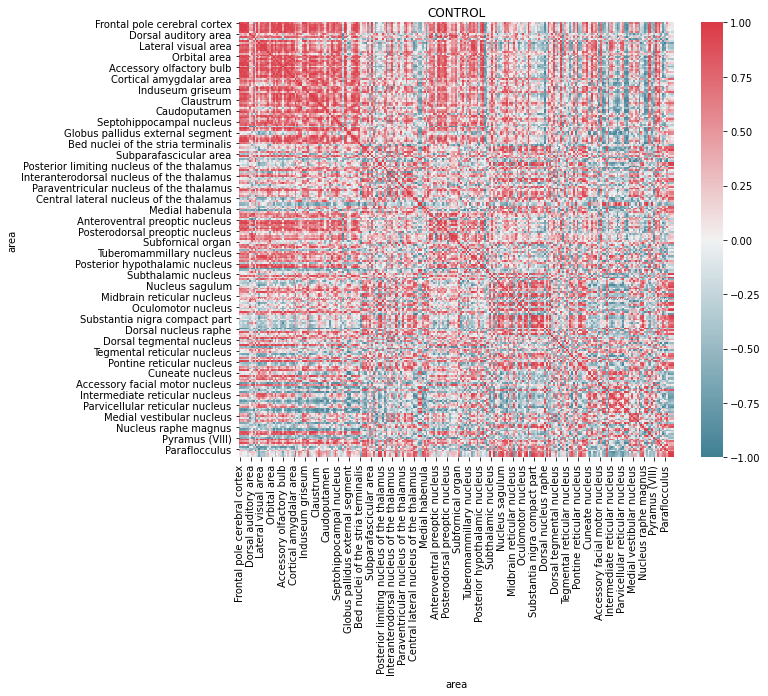

In [35]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

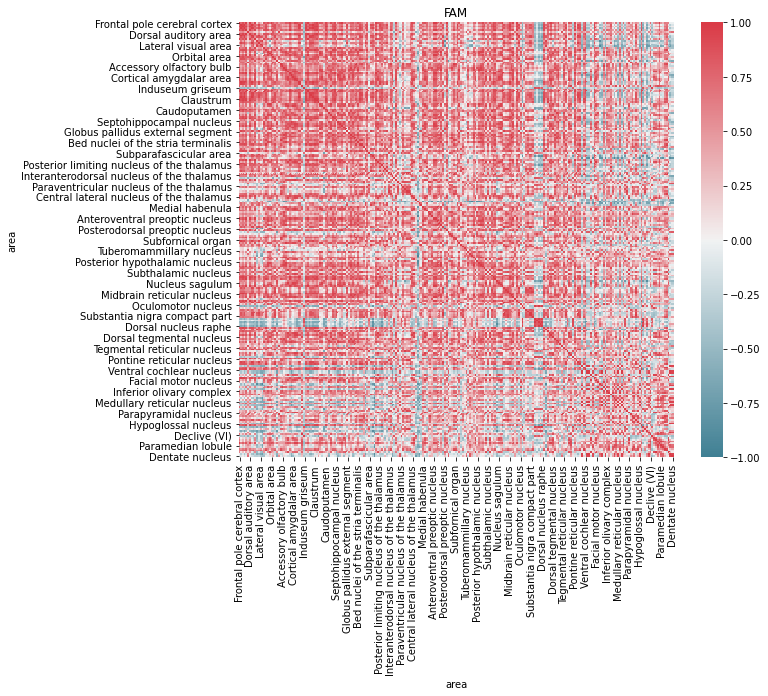

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

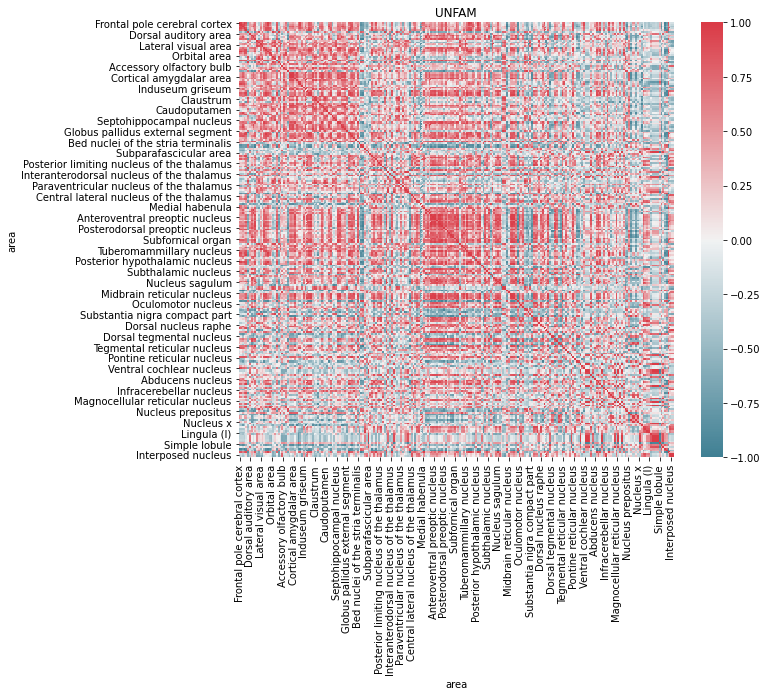

In [37]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [38]:
df_control_energy, df_fam_energy, df_unfam_energy = \
calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [39]:
df_control_energy

,area,SW25_Control,SW19_Control,SW24_Control,SW31_Control,SW30_Control
0,Frontal pole cerebral cortex,1.888729e+06,397178.794510,7.410365e+05,1.070748e+06,8.114752e+05
1,Primary motor area,1.543150e+06,383235.739685,4.208332e+05,8.901289e+05,1.084107e+06
2,Secondary motor area,2.495701e+06,644342.447341,8.535817e+05,1.182433e+06,1.558772e+06
3,Primary somatosensory area,2.458436e+06,442166.814601,5.826560e+05,1.140624e+06,1.844383e+06
4,Supplemental somatosensory area,1.960689e+06,459642.205793,2.722132e+05,7.737088e+05,1.285272e+06
...,...,...,...,...,...,...
293,Flocculus,2.017666e+06,115053.451479,1.557405e+06,2.072758e+06,2.111195e+05
294,Fastigial nucleus,7.040302e+03,0.000000,2.107360e+03,2.624050e+05,1.358731e+05
295,Interposed nucleus,6.050176e+04,3736.214294,1.691260e+04,4.288501e+05,1.332583e+05
296,Dentate nucleus,3.597064e+04,9504.277119,3.133985e+04,5.151069e+05,1.140120e+05


In [40]:
df_fam_energy

,area,SW27_Fam,SW23_Fam,SW21_Fam,SW29_Fam,SW33_Fam,SW35_Fam
0,Frontal pole cerebral cortex,1.183343e+06,147773.209548,0.000000,9.164654e+05,6.957166e+05,286954.580906
1,Primary motor area,8.471140e+05,97144.861956,112762.913723,8.412844e+05,1.168076e+06,153246.597228
2,Secondary motor area,1.373481e+06,236772.232819,32839.004938,1.257315e+06,1.394780e+06,505543.344895
3,Primary somatosensory area,8.823169e+05,166956.929627,296044.098777,9.745736e+05,1.138335e+06,217874.196570
4,Supplemental somatosensory area,7.693968e+05,203655.442616,108601.890603,7.372570e+05,5.155542e+05,264543.034321
...,...,...,...,...,...,...,...
293,Flocculus,7.925227e+05,35673.477546,144980.153172,2.933659e+06,1.378384e+06,471771.379163
294,Fastigial nucleus,1.008995e+05,4502.868502,0.000000,2.008443e+03,0.000000e+00,26557.032476
295,Interposed nucleus,3.319004e+04,4060.019533,2954.100102,2.164513e+04,1.800855e+03,129898.207762
296,Dentate nucleus,2.626959e+04,2577.764602,11347.411605,6.398497e+04,3.915185e+04,188655.637330


In [41]:
df_unfam_energy

,area,SW26_Unfam,SW20_Unfam,SW22_Unfam,SW28_Unfam,SW34_Unfam,SW32_Unfam
0,Frontal pole cerebral cortex,6.648653e+05,1.839136e+06,6.005096e+05,9.141968e+05,2.944091e+05,1.022515e+06
1,Primary motor area,6.475872e+05,1.361628e+06,5.982397e+05,9.345873e+05,3.320270e+05,1.079152e+06
2,Secondary motor area,1.275330e+06,1.594936e+06,9.984450e+05,1.326902e+06,4.022584e+05,1.755593e+06
3,Primary somatosensory area,1.083597e+06,1.644930e+06,7.800631e+05,1.211446e+06,5.407236e+05,1.105529e+06
4,Supplemental somatosensory area,7.318295e+05,1.460411e+06,7.393655e+05,1.171226e+06,4.368560e+05,6.111929e+05
...,...,...,...,...,...,...,...
293,Flocculus,1.435154e+06,5.093537e+05,1.678697e+06,3.771711e+05,1.521445e+06,1.345116e+06
294,Fastigial nucleus,0.000000e+00,6.752152e+04,1.952533e+03,5.618049e+04,4.558778e+03,3.144267e+04
295,Interposed nucleus,3.459734e+03,1.994391e+04,2.505007e+04,9.467816e+04,5.168679e+04,4.956711e+03
296,Dentate nucleus,0.000000e+00,3.461288e+04,2.314085e+04,1.129494e+05,9.693182e+04,1.317743e+04


## T-test on energy across groups

In [42]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.185487,0.785225,0.251859
1,Primary motor area,0.285663,0.883719,0.265254
2,Secondary motor area,0.209231,0.747741,0.211251
3,Primary somatosensory area,0.119602,0.560198,0.0849878
4,Supplemental somatosensory area,0.122787,0.783981,0.0530352
...,...,...,...,...
293,Flocculus,0.715001,0.915818,0.717309
294,Fastigial nucleus,0.269694,0.29301,0.82426
295,Interposed nucleus,0.226143,0.220786,0.967286
296,Dentate nucleus,0.371696,0.313621,0.806764


In [43]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.185487,0.785225,0.251859
1,Primary motor area,0.285663,0.883719,0.265254
2,Secondary motor area,0.209231,0.747741,0.211251
3,Primary somatosensory area,0.119602,0.560198,0.0849878
4,Supplemental somatosensory area,0.122787,0.783981,0.0530352
...,...,...,...,...
292,Paraflocculus,0.939695,0.825517,0.797342
293,Flocculus,0.715001,0.915818,0.717309
294,Fastigial nucleus,0.269694,0.29301,0.82426
295,Interposed nucleus,0.226143,0.220786,0.967286


In [44]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Anteromedial visual area,0.0146284
Subfornical organ,0.0260016
Ventral premammillary nucleus,0.0302415
Fundus of striatum,0.0341842
Accessory facial motor nucleus,0.0395188
Central amygdalar nucleus,0.0416319
Submedial nucleus of the thalamus,0.0448192
Paramedian lobule,0.057508
Posterior limiting nucleus of the thalamus,0.0667641


In [45]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.00800114
Dorsal premammillary nucleus,0.0248783
Locus ceruleus,0.0268629
Parapyramidal nucleus,0.0272878
Accessory olfactory bulb,0.0283263
Globus pallidus external segment,0.0302643
Infracerebellar nucleus,0.0367609
Periventricular hypothalamic nucleus posterior part,0.0476294
Infralimbic area,0.0487935


In [46]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsal auditory area,0.00742682
Ventral posterior complex of the thalamus,0.0104782
Simple lobule,0.0231391
Vascular organ of the lamina terminalis,0.0257758
Triangular nucleus of septum,0.0287272
Superior colliculus sensory related,0.0290499
Anterior olfactory nucleus,0.03024
Taenia tecta,0.0387276
Periventricular hypothalamic nucleus preoptic part,0.0389575


## Mann-Whitney Test across groups

In [47]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.117667,0.324038,0.189239
1,Primary motor area,0.117667,0.463632,0.148977
2,Secondary motor area,0.157651,0.463632,0.148977
3,Primary somatosensory area,0.0603454,0.392096,0.0641026
4,Supplemental somatosensory area,0.0603454,0.463632,0.0641026
...,...,...,...,...
293,Flocculus,0.324038,0.392096,0.189239
294,Fastigial nucleus,0.203508,0.35719,0.286238
295,Interposed nucleus,0.117667,0.205657,0.287587
296,Dentate nucleus,0.324038,0.205657,0.468093


In [48]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.117667,0.324038,0.189239
1,Primary motor area,0.117667,0.463632,0.148977
2,Secondary motor area,0.157651,0.463632,0.148977
3,Primary somatosensory area,0.0603454,0.392096,0.0641026
4,Supplemental somatosensory area,0.0603454,0.463632,0.0641026
...,...,...,...,...
292,Paraflocculus,0.463632,0.463632,0.468093
293,Flocculus,0.324038,0.392096,0.189239
294,Fastigial nucleus,0.203508,0.35719,0.286238
295,Interposed nucleus,0.117667,0.205657,0.287587


In [49]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Paramedian reticular nucleus,0.00405656
Efferent cochlear group,0.00405656
Intercollicular nucleus,0.00405656
Pineal body,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Substantia nigra lateral part,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Lobule V,0.00405656


In [50]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Superior salivatory nucleus,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Lateral tegmental nucleus,0.00405656
Nucleus z,0.00405656
Accessory abducens nucleus,0.00405656
Efferent vestibular nucleus,0.00405656
Substantia nigra lateral part,0.00405656
Efferent cochlear group,0.00405656


In [51]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory abducens nucleus,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Paramedian reticular nucleus,0.00405656
Interstitial nucleus of the vestibular nerve,0.00405656
Nucleus intercalatus,0.00405656
Lateral strip of striatum,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Nucleus circularis,0.00405656
Granular lamina of the cochlear nuclei,0.00405656


## Calculate cross corr matrix across experimental groups on energy

In [52]:
corr_matrix_control_energy = cross_corr(df_control_energy)
corr_matrix_control_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.891234,0.928834,0.844642,0.844244,0.948556,-0.033568,0.178082,0.668724,-0.568574,...,0.916656,0.774697,0.901388,0.574746,-0.522017,0.022470,0.710314,0.023210,0.162811,0.096128
Primary motor area,0.891234,1.000000,0.975917,0.987628,0.976718,0.899413,0.419196,0.507351,0.914757,-0.157770,...,0.797414,0.672791,0.972774,0.255792,-0.471403,-0.193470,0.387806,0.179638,0.212526,0.107558
Secondary motor area,0.928834,0.975917,1.000000,0.975258,0.973706,0.971186,0.306166,0.365700,0.816907,-0.274671,...,0.874772,0.598001,0.933050,0.267895,-0.638358,-0.251546,0.416963,-0.021638,0.031668,-0.066730
Primary somatosensory area,0.844642,0.987628,0.975258,1.000000,0.981633,0.898011,0.500430,0.482137,0.896660,-0.096661,...,0.759501,0.551313,0.945305,0.155879,-0.550757,-0.276841,0.286977,0.104139,0.105332,-0.006215
Supplemental somatosensory area,0.844244,0.976718,0.973706,0.981633,1.000000,0.909052,0.459929,0.554655,0.900435,-0.059594,...,0.830499,0.549033,0.900916,0.083406,-0.589591,-0.396018,0.239719,0.015283,0.034955,-0.072882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.022470,-0.193470,-0.251546,-0.276841,-0.396018,-0.243763,-0.459439,-0.466589,-0.267996,-0.547376,...,-0.292974,0.397418,0.036034,0.800668,0.596889,1.000000,0.665111,0.590463,0.680715,0.734320
Flocculus,0.710314,0.387806,0.416963,0.286977,0.239719,0.494055,-0.562777,-0.312026,0.131902,-0.895802,...,0.511547,0.780546,0.534006,0.979407,-0.030528,0.665111,1.000000,0.230292,0.440176,0.452269
Fastigial nucleus,0.023210,0.179638,-0.021638,0.104139,0.015283,-0.204681,0.302223,0.396409,0.397973,0.170987,...,-0.271940,0.537423,0.327426,0.327191,0.761467,0.590463,0.230292,1.000000,0.964421,0.943691


In [53]:
corr_matrix_fam_energy = cross_corr(df_fam_energy)
corr_matrix_fam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.829363,0.937700,0.829725,0.988621,0.493606,0.996549,0.722525,0.570384,0.968503,...,0.653160,0.658673,0.917772,0.554102,0.352827,0.679603,0.644061,0.618017,-0.051654,-0.045163
Primary motor area,0.829363,1.000000,0.954190,0.989942,0.830770,0.532522,0.865414,0.975984,0.862402,0.795707,...,0.241603,0.214287,0.635197,0.137126,-0.001539,0.543127,0.688052,0.211216,-0.298967,-0.159873
Secondary motor area,0.937700,0.954190,1.000000,0.936575,0.933076,0.634128,0.959354,0.893089,0.745323,0.876357,...,0.431546,0.472909,0.801050,0.407242,0.246267,0.672241,0.705985,0.396305,-0.084471,0.008829
Primary somatosensory area,0.829725,0.989942,0.936575,1.000000,0.844596,0.472237,0.867349,0.972796,0.899168,0.795784,...,0.216116,0.231501,0.614601,0.119091,0.020649,0.590616,0.748788,0.179463,-0.339529,-0.190950
Supplemental somatosensory area,0.988621,0.830770,0.933076,0.844596,1.000000,0.454695,0.991918,0.749005,0.640599,0.945275,...,0.557738,0.653376,0.859724,0.519487,0.399300,0.759004,0.744303,0.516500,-0.084560,-0.047050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.679603,0.543127,0.672241,0.590616,0.759004,0.520121,0.707780,0.544751,0.611769,0.509507,...,0.157797,0.719364,0.524617,0.584942,0.779819,1.000000,0.914768,0.090559,0.257043,0.402235
Flocculus,0.644061,0.688052,0.705985,0.748788,0.744303,0.346474,0.690903,0.744942,0.854981,0.521624,...,-0.076927,0.412716,0.360555,0.227520,0.477767,0.914768,1.000000,-0.139295,-0.117974,0.093183
Fastigial nucleus,0.618017,0.211216,0.396305,0.179463,0.516500,0.280206,0.557025,-0.002226,-0.252967,0.662627,...,0.997168,0.662611,0.850045,0.688148,0.234971,0.090559,-0.139295,1.000000,0.257988,0.028355


In [54]:
corr_matrix_unfam_energy = cross_corr(df_unfam_energy)
corr_matrix_unfam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.958198,0.757663,0.946161,0.848848,-0.566767,0.393943,0.243957,0.449004,0.717311,...,-0.223080,-0.261471,0.349453,-0.668315,0.159169,-0.940924,-0.704812,0.846765,-0.181992,-0.216901
Primary motor area,0.958198,1.000000,0.885764,0.935059,0.777554,-0.543401,0.435072,0.483826,0.676186,0.813886,...,-0.265899,-0.307806,0.466479,-0.778389,0.015119,-0.925971,-0.709300,0.866312,-0.147716,-0.217468
Secondary motor area,0.757663,0.885764,1.000000,0.820885,0.533764,-0.185038,0.488780,0.588042,0.870262,0.698183,...,-0.214941,-0.262627,0.450946,-0.845086,-0.103641,-0.767459,-0.465729,0.605259,-0.340223,-0.478589
Primary somatosensory area,0.946161,0.935059,0.820885,1.000000,0.882380,-0.450629,0.339897,0.289637,0.478892,0.720101,...,-0.327176,-0.345812,0.460308,-0.822455,0.000305,-0.978928,-0.777107,0.828511,-0.117816,-0.216691
Supplemental somatosensory area,0.848848,0.777554,0.533764,0.882380,1.000000,-0.709152,0.401342,0.240337,0.175787,0.773455,...,-0.111873,-0.096368,0.227282,-0.548060,0.223474,-0.848871,-0.877513,0.854973,0.228540,0.103946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,-0.940924,-0.925971,-0.767459,-0.978928,-0.848871,0.474658,-0.171341,-0.252320,-0.445948,-0.672577,...,0.484290,0.503342,-0.591470,0.844906,0.133347,1.000000,0.815871,-0.871200,0.064322,0.108418
Flocculus,-0.704812,-0.709300,-0.465729,-0.777107,-0.877513,0.752879,-0.083838,-0.414997,-0.248384,-0.773514,...,0.443935,0.412512,-0.578202,0.660523,0.201700,0.815871,1.000000,-0.936018,-0.522110,-0.439788
Fastigial nucleus,0.846765,0.866312,0.605259,0.828511,0.854973,-0.817574,0.219396,0.499156,0.432915,0.856547,...,-0.381625,-0.384253,0.558582,-0.666050,-0.102940,-0.871200,-0.936018,1.000000,0.335215,0.292081


## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

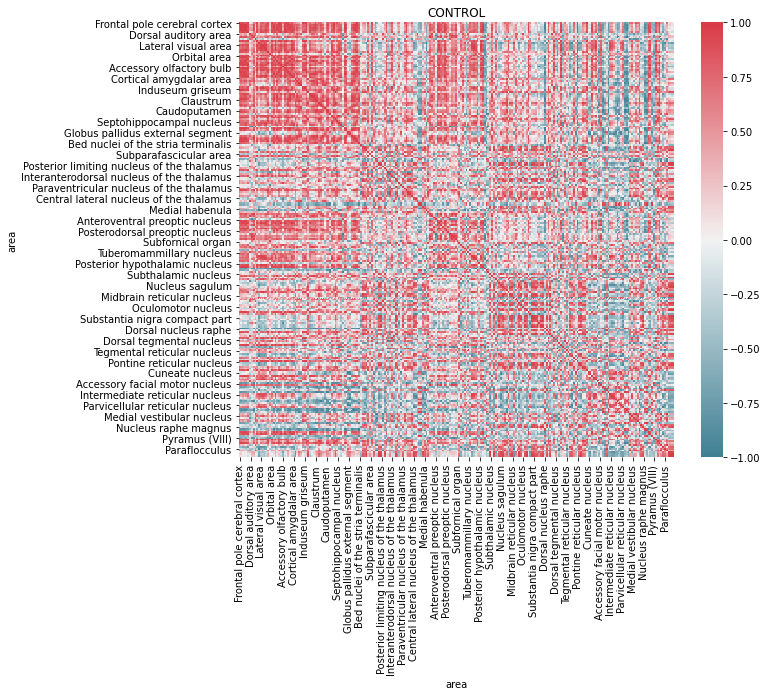

In [55]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

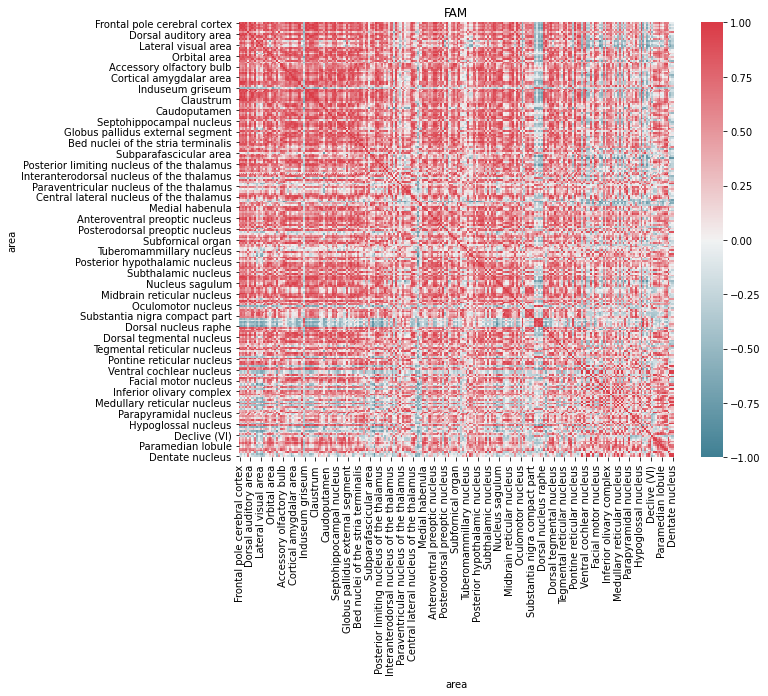

In [56]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

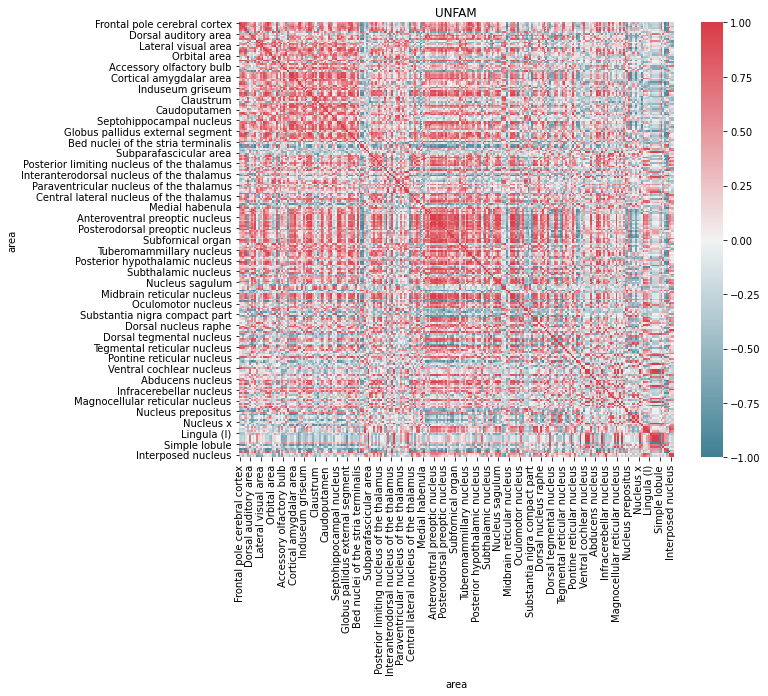

In [57]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')